In [1]:
import numpy as np
# Plotting libraries
import matplotlib.pylab as plt
# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline
# This enables high resolution PNGs.
%config InlineBackend.figure_formats = {'png', 'svg'}
import numpy as np
import matplotlib.pyplot as plt
import egttools as egt

from egttools.analytical import replicator_equation
from egttools.utils import find_saddle_type_and_gradient_direction
from egttools.plotting import plot_gradient
from egttools.analytical import StochDynamics
from egttools.analytical import replicator_equation
from egttools.utils import find_saddle_type_and_gradient_direction
from egttools.plotting import plot_gradient

In [2]:
cost = 6.5

In [81]:
import numpy as np

actions = np.asarray([cost, 0])

def is_the_same(type1,type2):
    return type1(0,0)==type2(0,0); #check if they are cooparating or not in round 0 so RM player or AD


# Let's estimate the payoffs through simulation

def always_defect(prev_contribution_group, t):
    return actions[1]


def r1(prev_contribution_group, t):
    """
    If prev_donations >= 1 -> coop
    else defect
    """
    if t == 0 or prev_contribution_group >= 1:
        return actions[0]  # coop
    else:
        return actions[1]  # defect
    
def r2(prev_contribution_group, t):
    """
    If prev_donations >= 2 -> coop
    else defect
    """
    if t == 0 or prev_contribution_group >= 2:
        return actions[0]  # coop
    else:
        return actions[1]  # defect

def r3(prev_contribution_group, t):
    """
    If prev_donations >= 3 -> coop
    else defect
    """
    if t == 0 or prev_contribution_group >= 3:
        return actions[0]  # coop
    else:
        return actions[1]  # defect

def r4(prev_contribution_group, t):
    """
    If prev_donations >= 4 -> coop
    else defect
    """
    if t == 0 or prev_contribution_group >= 4:
        return actions[0]  # coop
    else:
        return actions[1]  # defect
    
def r5(prev_contribution_group, t):
    """
    If prev_donations >= 5 -> coop
    else defect
    """
    if t == 0 or prev_contribution_group >= 5:
        return actions[0]  # coop
    else:
        return actions[1]  # defect

def npd(type1, type2, k, group_size, F, rounds):
    """
    Simulates a classical CRD (no timing uncertainty).
    :param F:
    :param cost:
    :param type1: [int] index of strategy 1
    :param type2: [int] index of strategy 2
    :param k: [int] number of group members adopting strategy 1
    :param group_size: [int] group size
    :param threshold: [int]
    :param r: [float] risk
    :param rounds: [int] total number of rounds
    :param endowment: [int] private endowment
    :return: [numpy.array] the payoffs of each strategy
    """
    payoffs = np.array([0, 0],dtype=float)
    
    if is_the_same(type1,type2):  # all members of the group adopt the same global strategy
        start_contrib = group_size
        total=0
        for i in range(rounds):
            if(np.random.rand()<start_contrib*0.01 and start_contrib>=1):
                prev_contrib=start_contrib-1
            else:
                prev_contrib=start_contrib
                
            don = type1(prev_contrib, i)
            total+=(prev_contrib * don)
            #if payoffs[0] >= don1: #if endowment
            if don > 0:  # all coop
                payoffs[0] -= don
                payoffs[1] -= don
                               
        payoffs[0]+= (total*F)/group_size
        payoffs[1]+= (total*F)/group_size

    else:
        
        if(type1(k, 0)==0):
            start_contrib = group_size-k
        else:
            start_contrib = k
        total=0
        for i in range(rounds):  # the members of the group adopt different strategies
            if(np.random.rand()<start_contrib*0.01 and start_contrib>=1):
                prev_contrib=start_contrib-1
            else:
                prev_contrib=start_contrib
            don1 = type1(prev_contrib, i)
            don2 = type2(prev_contrib, i)
            don = max(don1,don2)
            total+=(prev_contrib * don)    
            # if payoffs[0] >= don1: if endowment
            payoffs[0] -= don1  
            # if payoffs[1] >= don2: if endowment
            payoffs[1] -= don2 

        payoffs[0]+= (total*F)/group_size
        payoffs[1]+= (total*F)/group_size

    return payoffs/rounds


class EstimatePayoffsNPD(object):
    strategies = ['R1','R2','R3','R4','R5''AL_DEFECT']
    strategies_caller = [r1,r2,r3,r4,r5,always_defect]
    ns = len(strategies)

    @staticmethod
    def estimate_payoff(invader, resident, group_size, F, rounds, iterations=100):
        """
        Estimates the payoff for invader and resident strategies,
        for the classical CRD.
        :param cost:
        :param F:
        :param invader: [int] index of the invading strategy
        :param resident: [int] index of the resident strategy
        :param group_size: [int] group size
        :param threshold: [int] contribution threshold for the conditional strategies
        :param r: [float] risk
        :param rounds: [int] number of rounds
        :param w: parameter not used
        :param iterations: [int] number of iterations used to average the game results
               (only relevant for stochastic results)
        :return: [lambda] function that returns the payoff of a crd group for each possible
                configuration of invader and resident strategies
        """
        payoffs = []
        for i in range(1, int(group_size) + 1):
            avg = 0.
            for _ in range(iterations):
                avg += npd(invader, resident, i, group_size, F, rounds)[0]
            payoffs.append(avg / float(iterations))

        # k is the number of invaders and z a dummy parameter
        return lambda k, z: payoffs[int(k) - 1]

    @staticmethod
    def estimate_payoffs(group_size, F, m0,
                         iterations=1000, save_name=None):
        """
        Estimates the payoffs of each strategy when playing against another.
        :param cost:
        :param F:
        :param group_size: [int] group size
        :param threshold: [int] contribution threshold for the conditional strategies
        :param r: [float] risk
        :param m0: [int] minimum number of rounds
        :param w: [float] probability that the game will and after the minimum number of rounds
        :param iterations: [int] number of iterations used to average the game results
        :param save_name: [string] name/path of file to save results, if None, the results are not saved
        :return: [numpy.array] the estimated payoffs
        """

        estimate = EstimatePayoffsNPD.estimate_payoff

        payoffs = np.asarray([[estimate(i, j, group_size, F, m0, iterations)
                                   for j in EstimatePayoffsNPD.strategies_caller] for i in
                                  EstimatePayoffsNPD.strategies_caller])

        return payoffs

In [82]:
R=(1-0.9)**-1
F=4.25
N=5
nb_strategies = 6; Z = 100; N = 5;
nb_runs=50
beta = 1
mean_stationary_distribution=np.zeros([nb_strategies])
mean_fixation_probabilities=np.zeros([nb_strategies,nb_strategies])

for runs in range(nb_runs):
    estimate = EstimatePayoffsNPD()
    payoffs=estimate.estimate_payoffs(N, F, round(R),10)
    evolver= StochDynamics(nb_strategies, payoffs, Z,N)
    evolver.mu = 0
    transition_matrix,fixation_probabilities = evolver.transition_and_fixation_matrix(beta)
    stationary_distribution=egt.utils.calculate_stationary_distribution(transition_matrix)
    mean_stationary_distribution+=stationary_distribution
    mean_fixation_probabilities+=fixation_probabilities

mean_stationary_distribution/=nb_runs
mean_fixation_probabilities/=nb_runs



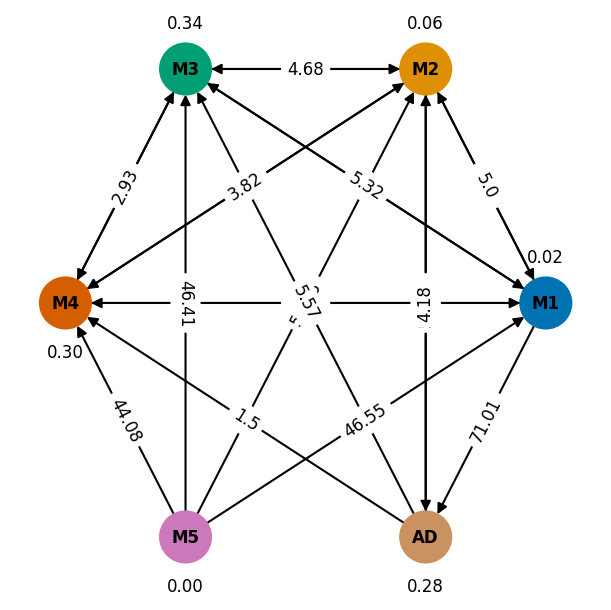

In [94]:
strategy_labels=["M1","M2","M3","M4","M5","AD"]
ig, ax = plt.subplots(figsize=(5, 5), dpi=150)
G = egt.plotting.draw_stationary_distribution(strategy_labels,
                                              1/Z, mean_fixation_probabilities, mean_stationary_distribution,
                                              node_size=600,
                                              font_size_node_labels=8,
                                              font_size_edge_labels=8,
                                              font_size_sd_labels=8,
                                              edge_width=1,
                                              min_strategy_frequency=0.00001,
                                              ax=ax)
plt.axis('off')
plt.show() # display

In [85]:
print(mean_fixation_probabilities)

[[ 0.          3.17235382  2.76143155  3.85412135  0.         71.00526533]
 [ 5.00361021  0.          3.61380283  4.15195686  0.         54.30952964]
 [ 5.31706109  4.67742335  0.          3.86376199  0.          0.        ]
 [ 3.97742726  3.81776827  2.9301783   0.          0.          0.        ]
 [46.54691099 50.68322796 46.40942296 44.07603652  0.          0.        ]
 [ 0.          4.17791876  5.57096534  1.50005231  0.24635776  0.        ]]


In [24]:
M1=[]
M2=[]
M3=[]
M4=[]
M5=[]
AD=[]
test_values=[3.75,4.,4.25,4.5]
for F in test_values:
    payoffs=estimateM1AD.estimate_payoffs(N, F, round(R),10)
    nb_strategies = 6; Z = 100; N = 5;
    beta = 1
    evolver= StochDynamics(nb_strategies, payoffs, Z,N)
    evolver.mu = 0
    stationary_SML = evolver.calculate_stationary_distribution(beta)
    transition_matrix,fixation_probabilities = evolver.transition_and_fixation_matrix(beta)
    stationary_distribution = egt.utils.calculate_stationary_distribution(transition_matrix)
    M1.append(stationary_distribution[0])
    M2.append(stationary_distribution[1])
    M3.append(stationary_distribution[2])
    M4.append(stationary_distribution[3])
    M5.append(stationary_distribution[4])
    AD.append(stationary_distribution[5])

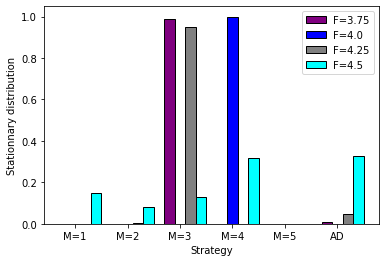

In [25]:
F375 = (M1[0], M2[0], M3[0], M4[0], M5[0], AD[0])
F400 = (M1[1], M2[1], M3[1], M4[1], M5[1], AD[1])
F425 = (M1[2], M2[2], M3[2], M4[2], M5[2], AD[2])
F450 = (M1[3], M2[3], M3[3], M4[3], M5[3], AD[3])
x = np.arange(6)
width = 0.2  # the width of the bars
# plot data in grouped manner of bar type
plt.bar(x-width, F375, width, color='purple',edgecolor='black')
plt.bar(x, F400, width, color='blue',edgecolor='black')
plt.bar(x+width, F425, width, color='grey',edgecolor='black')
plt.bar(x+2*width, F450, width, color='cyan',edgecolor='black')
plt.xticks(x, ['M=1', 'M=2', 'M=3', 'M=4', 'M=5','AD'])
plt.legend(["F=3.75", "F=4.0", "F=4.25","F=4.5"])
plt.xlabel("Strategy")
plt.ylabel("Stationnary distribution")
plt.show()



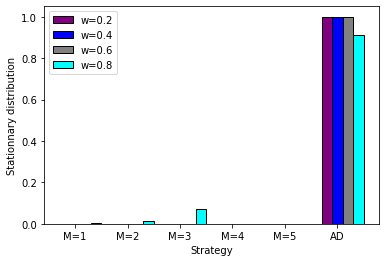

In [26]:
M1=[]
M2=[]
M3=[]
M4=[]
M5=[]
AD=[]
test_values=[0.2,0.4,0.6,0.8]
for w in test_values:
    cost=6.5
    actions = np.asarray([cost, 0])
    R=(1-w)**-1
    payoffs=estimateM1AD.estimate_payoffs(N, 4.25, round(R),10)
    nb_strategies = 6; Z = 100; N = 5;
    beta = 1
    evolver= StochDynamics(nb_strategies, payoffs, Z,N)
    evolver.mu = 0
    stationary_SML = evolver.calculate_stationary_distribution(beta)
    transition_matrix,fixation_probabilities = evolver.transition_and_fixation_matrix(beta)
    stationary_distribution = egt.utils.calculate_stationary_distribution(transition_matrix)
    M1.append(stationary_distribution[0])
    M2.append(stationary_distribution[1])
    M3.append(stationary_distribution[2])
    M4.append(stationary_distribution[3])
    M5.append(stationary_distribution[4])
    AD.append(stationary_distribution[5])
    
F375 = (M1[0], M2[0], M3[0], M4[0], M5[0], AD[0])
F400 = (M1[1], M2[1], M3[1], M4[1], M5[1], AD[1])
F425 = (M1[2], M2[2], M3[2], M4[2], M5[2], AD[2])
F450 = (M1[3], M2[3], M3[3], M4[3], M5[3], AD[3])
x = np.arange(6)
width = 0.2  # the width of the bars
# plot data in grouped manner of bar type
plt.bar(x-width, F375, width, color='purple',edgecolor='black')
plt.bar(x, F400, width, color='blue',edgecolor='black')
plt.bar(x+width, F425, width, color='grey',edgecolor='black')
plt.bar(x+2*width, F450, width, color='cyan',edgecolor='black')
plt.xticks(x, ['M=1', 'M=2', 'M=3', 'M=4', 'M=5','AD'])
plt.legend(["w=0.2", "w=0.4", "w=0.6","w=0.8"])

plt.xlabel("Strategy")
plt.ylabel("Stationnary distribution")
plt.show()


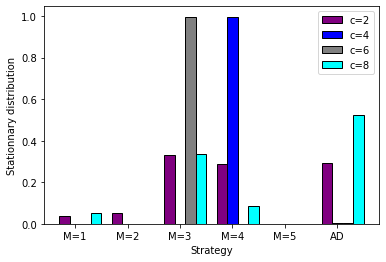

In [27]:
M1=[]
M2=[]
M3=[]
M4=[]
M5=[]
AD=[]
test_values=[2,4,6,8]
for cost in test_values:
    R=(1-0.9)**-1
    actions = np.asarray([cost, 0])
    payoffs=estimateM1AD.estimate_payoffs(N, 4.25, round(R),10)
    nb_strategies = 6; Z = 100; N = 5;
    beta = 1
    evolver= StochDynamics(nb_strategies, payoffs, Z,N)
    evolver.mu = 0
    stationary_SML = evolver.calculate_stationary_distribution(beta)
    transition_matrix,fixation_probabilities = evolver.transition_and_fixation_matrix(beta)
    stationary_distribution = egt.utils.calculate_stationary_distribution(transition_matrix)
    M1.append(stationary_distribution[0])
    M2.append(stationary_distribution[1])
    M3.append(stationary_distribution[2])
    M4.append(stationary_distribution[3])
    M5.append(stationary_distribution[4])
    AD.append(stationary_distribution[5])
    
F375 = (M1[0], M2[0], M3[0], M4[0], M5[0], AD[0])
F400 = (M1[1], M2[1], M3[1], M4[1], M5[1], AD[1])
F425 = (M1[2], M2[2], M3[2], M4[2], M5[2], AD[2])
F450 = (M1[3], M2[3], M3[3], M4[3], M5[3], AD[3])
x = np.arange(6)
width = 0.2  # the width of the bars
# plot data in grouped manner of bar type
plt.bar(x-width, F375, width, color='purple',edgecolor='black')
plt.bar(x, F400, width, color='blue',edgecolor='black')
plt.bar(x+width, F425, width, color='grey',edgecolor='black')
plt.bar(x+2*width, F450, width, color='cyan',edgecolor='black')
plt.xticks(x, ['M=1', 'M=2', 'M=3', 'M=4', 'M=5','AD'])
plt.legend(["c=2", "c=4", "c=6","c=8"])

plt.xlabel("Strategy")
plt.ylabel("Stationnary distribution")
plt.show()


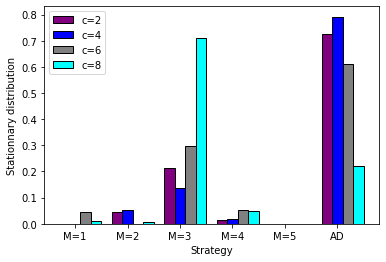

In [28]:
M1=[]
M2=[]
M3=[]
M4=[]
M5=[]
AD=[]
test_values=[0.001,0.01,0.1,1]
for mutation in test_values:
    R=(1-0.9)**-1
    cost=6.5
    actions = np.asarray([cost, 0])
    payoffs=estimateM1AD.estimate_payoffs(N, 4.25, round(R),10)
    nb_strategies = 6; Z = 100; N = 5;
    beta = 1
    evolver= StochDynamics(nb_strategies, payoffs, Z,N)
    evolver.mu = mutation
    stationary_SML = evolver.calculate_stationary_distribution(beta)
    transition_matrix,fixation_probabilities = evolver.transition_and_fixation_matrix(beta)
    stationary_distribution = egt.utils.calculate_stationary_distribution(transition_matrix)
    M1.append(stationary_distribution[0])
    M2.append(stationary_distribution[1])
    M3.append(stationary_distribution[2])
    M4.append(stationary_distribution[3])
    M5.append(stationary_distribution[4])
    AD.append(stationary_distribution[5])
    
F375 = (M1[0], M2[0], M3[0], M4[0], M5[0], AD[0])
F400 = (M1[1], M2[1], M3[1], M4[1], M5[1], AD[1])
F425 = (M1[2], M2[2], M3[2], M4[2], M5[2], AD[2])
F450 = (M1[3], M2[3], M3[3], M4[3], M5[3], AD[3])
x = np.arange(6)
width = 0.2  # the width of the bars
# plot data in grouped manner of bar type
plt.bar(x-width, F375, width, color='purple',edgecolor='black')
plt.bar(x, F400, width, color='blue',edgecolor='black')
plt.bar(x+width, F425, width, color='grey',edgecolor='black')
plt.bar(x+2*width, F450, width, color='cyan',edgecolor='black')
plt.xticks(x, ['M=1', 'M=2', 'M=3', 'M=4', 'M=5','AD'])
plt.legend(["c=2", "c=4", "c=6","c=8"])

plt.xlabel("Strategy")
plt.ylabel("Stationnary distribution")
plt.show()

In [ ]:
beta = 1
mu = 1e-3
Z=100
transitory=10**1
nb_generations=10**3
nb_runs=100

R=round((1-0.9)**-1)
c=2

F=3.5
#Cheater will be 0
#Mn will be n